In [2]:
import numpy as np
import math
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# function for generating mean and variance
def gen_parameters(figure, noise=0.01, seed=0):
    
    np.random.seed(seed)
    
    mean = np.random.rand(9, 9)
    
    var = figure*noise
    
    return mean, var

In [6]:
import numpy as np

# Define the size of the matrix (e.g., 9x9)
size = 12

# Create an empty matrix filled with zeros
circle_matrix_out = np.zeros((size, size), dtype=int)

# Set the center coordinates
center_x, center_y = size // 2, size // 2

# Set the radius of the circle
radius = 3

# Iterate through each cell in the matrix
for i in range(size):
    for j in range(size):
        # Calculate the distance from the center
        distance = np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2)
        # Use a Gaussian-like distribution to set the value
        circle_matrix_out[i, j] = int(round(3 * np.exp(-0.5 * (distance / radius) ** 2)))

# Print the circle matrix
for row in circle_matrix_out:
    print(" ".join(map(str, row)))


0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 1 1 0 0 0
0 0 1 1 1 1 1 1 1 1 1 0
0 0 1 1 1 2 2 2 1 1 1 0
0 1 1 1 2 2 2 2 2 1 1 1
0 1 1 2 2 3 3 3 2 2 1 1
0 1 1 2 2 3 3 3 2 2 1 1
0 1 1 2 2 3 3 3 2 2 1 1
0 1 1 1 2 2 2 2 2 1 1 1
0 0 1 1 1 2 2 2 1 1 1 0
0 0 1 1 1 1 1 1 1 1 1 0
0 0 0 0 1 1 1 1 1 0 0 0


In [8]:
mean, var = gen_parameters(circle_matrix)

True data uncertainty (variance)


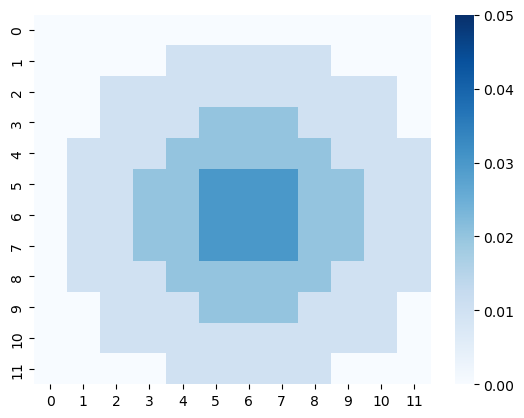

In [11]:
print("True data uncertainty (variance)")
sns.heatmap(var, cmap="Blues", vmax=0.05)
plt.savefig("heart_data_gt.pdf")
plt.show()

In [52]:
import numpy as np

# Define the size of the matrix (e.g., 9x9)
size = 9

# Create an empty matrix filled with zeros
circle_matrix = np.zeros((size, size), dtype=int)

# Set the center coordinates
center_x, center_y = size // 2, size // 2

# Set the radius of the circle
radius = 3.5

# Iterate through each cell in the matrix
for i in range(size):
    for j in range(size):
        # Calculate the distance from the center
        distance = np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2)
        # Determine the value based on the distance
        if distance <= radius:
            # Innermost area near the center (value 0)
            circle_matrix[i, j] = 0

        elif distance <= radius + 0.2:
            # Portion along the border (value 2)
            circle_matrix[i, j] = 4

        elif distance <= radius + 0.5:
            # Portion along the border (value 2)
            circle_matrix[i, j] = 3
        else:
            # Area outside the circle (value 1)
            circle_matrix[i, j] = 1

# Print the circle matrix
for row in circle_matrix:
    print(" ".join(map(str, row)))


1 1 1 1 3 1 1 1 1
1 1 4 0 0 0 4 1 1
1 4 0 0 0 0 0 4 1
1 0 0 0 0 0 0 0 1
3 0 0 0 0 0 0 0 3
1 0 0 0 0 0 0 0 1
1 4 0 0 0 0 0 4 1
1 1 4 0 0 0 4 1 1
1 1 1 1 3 1 1 1 1


In [53]:
mean, var = gen_parameters(circle_matrix)

True data uncertainty (variance)


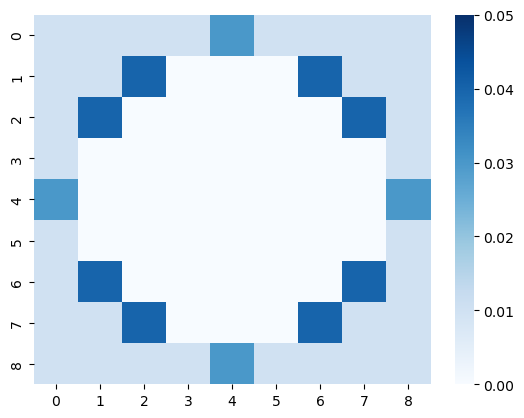

In [54]:
print("True data uncertainty (variance)")
sns.heatmap(var, cmap="Blues", vmax=0.05)
plt.savefig("circle_data_gt.pdf")
plt.show()

In [58]:
# function for generating train and validation sets
def generate_training_data(n_samples, mean, var, num_cat=9, seed=0):
    np.random.seed(seed)
    train = []
    target = []
    val = []
    val_target = []
    for i in range(num_cat):
        for j in range(num_cat):
            if var[i, j] == 0:
                continue
            for _ in range(n_samples):
                train.append([i, j])
                val.append([i, j])
                target.append(np.random.normal(mean[i, j], math.sqrt(var[i, j])))
                val_target.append(np.random.normal(mean[i, j], math.sqrt(var[i, j])))
                
    train = np.asarray(train)
    target = np.asarray(target)

    return train, target, val, val_target

In [56]:
train, target, val, val_target = generate_training_data(1000, mean, var)

train_pool = Pool(train, target, cat_features = [0, 1])
val_pool = Pool(val, val_target, cat_features = [0, 1])

num_cat = 9
test = np.asarray([[i, j] for i in range(num_cat) for j in range(num_cat)])

In [59]:
def ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.3):
    ens_preds = []

    for seed in range(num_samples):
        model = CatBoostRegressor(random_seed=seed, iterations=iters, learning_rate=lr, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  bootstrap_type='No', verbose=False)
        model.fit(train_pool, eval_set=val_pool, use_best_model=False)
        print("best iteration =", model.get_best_iteration())
        ens_preds.append(model.predict(test))
    return ens_preds

ens_preds = ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.3)
ens_preds = np.asarray(ens_preds)

best iteration = 702
best iteration = 987
best iteration = 974
best iteration = 960
best iteration = 998
best iteration = 994
best iteration = 987
best iteration = 944
best iteration = 787
best iteration = 980


Average predicted data uncertainty:


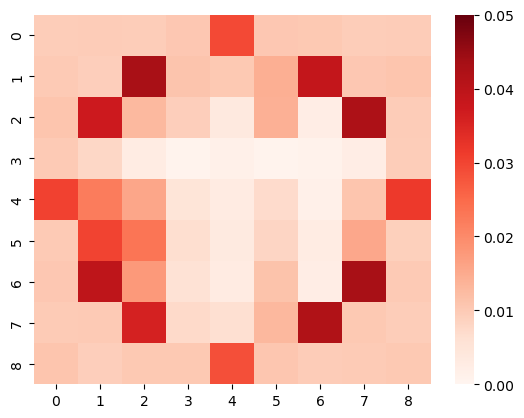

Knowledge uncertainty via ensemble:


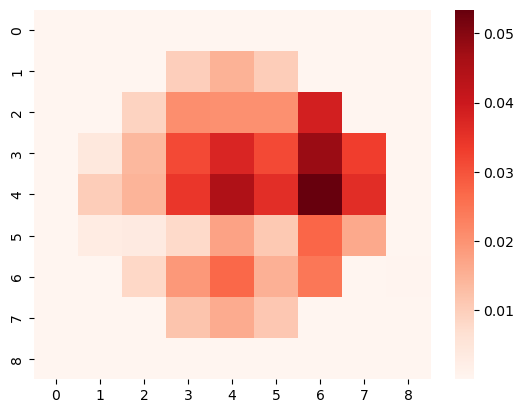

In [60]:
data = np.mean(ens_preds, axis=0)[:, 1] # average estimated data uncertainty
knowledge = np.var(ens_preds, axis=0)[:, 0] # estimated knowledge uncertainty

print("Average predicted data uncertainty:")            
sns.heatmap(data.reshape([num_cat, num_cat]), cmap="Reds", vmin=0, vmax=0.05)
plt.savefig("heart_data_sglb.pdf")
plt.show()

print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([num_cat, num_cat]), cmap="Reds")
plt.savefig("heart_knowledge_sglb.pdf")
plt.show()

True data uncertainty (variance)


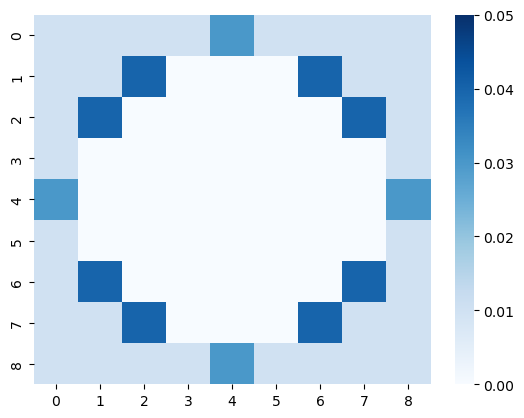

In [61]:
print("True data uncertainty (variance)")
sns.heatmap(var, cmap="Blues", vmax=0.05)
plt.savefig("circle_data_gt.pdf")
plt.show()

In [63]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.3, loss_function='RMSEWithUncertainty', 
                          posterior_sampling=True, bootstrap_type='No', random_seed=0, verbose=False)
model.fit(train_pool, eval_set=val_pool, use_best_model=False)
preds = model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty', virtual_ensembles_count=10)

Average predicted data uncertainty:


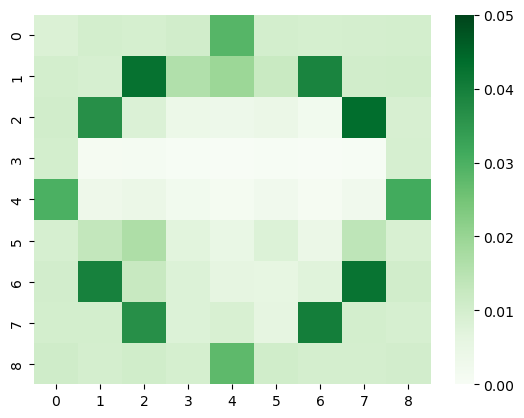

Knowledge uncertainty via virtual ensemble:


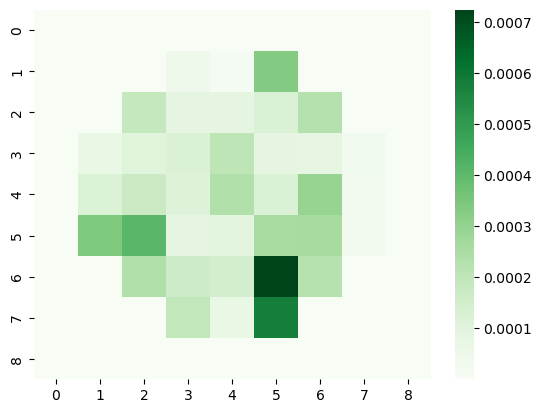

In [65]:
mean_preds = preds[:,0] # mean values predicted by a virtual ensemble

data = preds[:,2] # estimated data uncertainty
print("Average predicted data uncertainty:")
sns.heatmap(data.reshape([num_cat,num_cat]), cmap="Greens", vmin = 0, vmax = 0.05)
plt.savefig("heart_data_vsglb.pdf")
plt.show()

knowledge = preds[:,1] # knowledge uncertainty
print("Knowledge uncertainty via virtual ensemble:")
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Greens")
plt.savefig("heart_knowledge_vsglb.pdf")
plt.show()

In [66]:
def ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.1):
    ens_preds = []
    for seed in range(num_samples):
        model = CatBoostRegressor(random_seed=seed, iterations=iters, learning_rate=lr, 
                                  loss_function='RMSEWithUncertainty', subsample=0.5,
                                  bootstrap_type='Bernoulli', verbose=False)
        model.fit(train_pool, eval_set=val_pool, use_best_model=False)
        print("best iteration =", model.get_best_iteration()) # check that best iteration is reasonable
        ens_preds.append(model.predict(test))
    return ens_preds

ens_preds = ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.1)
ens_preds = np.asarray(ens_preds)

best iteration = 728
best iteration = 943
best iteration = 836
best iteration = 521
best iteration = 662
best iteration = 800
best iteration = 910
best iteration = 611
best iteration = 690
best iteration = 900


In [ ]:
data = np.mean(ens_preds, axis=0)[:, 1] # average estimated data uncertainty
knowledge = np.var(ens_preds, axis=0)[:, 0] # estimated knowledge uncertainty

print("Average predicted data uncertainty:")            
sns.heatmap(data.reshape([num_cat, num_cat]), cmap="Reds", vmin=0, vmax=0.05)
# plt.savefig("heart_data_sgb.pdf")
plt.show()

print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([num_cat, num_cat]), cmap="Reds")
# plt.savefig("heart_knowledge_sgb.pdf")
plt.show()

In [ ]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, loss_function='RMSEWithUncertainty', 
                          subsample=0.5, bootstrap_type='Bernoulli', random_seed=0, verbose=False)
model.fit(train_pool, eval_set=val_pool, use_best_model=False)
preds = model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty', virtual_ensembles_count=10)

In [ ]:
mean_preds = preds[:,0] # mean values predicted by a virtual ensemble

data = preds[:,2] # estimated data uncertainty
print("Average predicted data uncertainty:")
sns.heatmap(data.reshape([num_cat,num_cat]), cmap="Reds", vmin = 0, vmax = 0.05)
# plt.savefig("heart_data_vsgb.pdf")
plt.show()

knowledge = preds[:,1] # knowledge uncertainty
print("Knowledge uncertainty via virtual ensemble:")
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
# plt.savefig("heart_knowledge_vsgb.pdf")
plt.show()